<a href="https://colab.research.google.com/github/QuocHuy-1602/Melanoma_Cancer_Detection/blob/main/Melanoma_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Dataset and Module

In [ ]:
!wget -O data.zip https://drive.google.com/file/d/1eQXnbgzocR20dSafG4Du9AiBmjCnl4FO/view?usp=drive_link

In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 43.8 MB/s eta 0:00:00


In [ ]:
!unzip 'data.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1348.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_250.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_2562.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_9789.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_4086.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_3030.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_4665.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1161.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_3931.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_804.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_204.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1533.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1695.jpg  
  inflating: melanoma_cancer_dataset

## Import Libraries and Set Seed values

In [ ]:
from glob import glob
import pandas as pd
import numpy as np
import os
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import random
from lightning.pytorch.callbacks import ModelSummary
import random
import shutil

def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 0


## Spit Dataset

In [ ]:
# Create the validation folder
val_path = '/content/melanoma_cancer_dataset/validation/'
train_path = '/content/melanoma_cancer_dataset/train/'
list_ = [name for name in os.listdir(train_path)]

os.makedirs(val_path, exist_ok = True)
for name in list_:
  label_folder = os.path.join(val_path, name)
  os.makedirs(label_folder, exist_ok = True)

In [ ]:
nums_train = {}

for name in list_:
  label_folder = os.path.join(train_path, name)
  file_names = [name for name in os.listdir(label_folder)]
  nums_train[name] = len(file_names)
  train, val = train_test_split(file_names, test_size=0.2, random_state=0)

  for image in val:
    src_path = os.path.join(label_folder, image)
    des_path = os.path.join(val_path, name)
    shutil.move(src_path, des_path)

<Axes: title={'center': 'Class Distribution '}, xlabel='Type', ylabel='Number of image'>

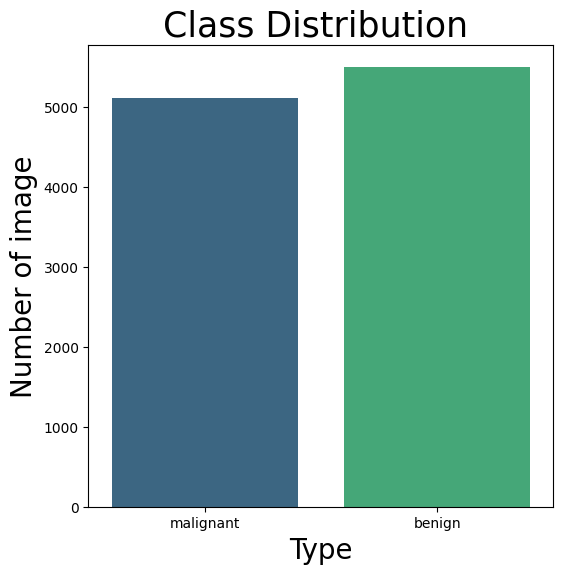

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Class Distribution ',fontsize=25)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)
sns.barplot(x=keys, y=vals, hue=keys, palette='viridis', legend=False)

In [ ]:
NAME2NUMBER = {}
for index, label in enumerate(list_):
  NAME2NUMBER[label] = index

def get_path(path):
  paths = []
  for name in list_:
    l = glob(f"{path}{name}/*.jpg")
    for i in l:
      paths.append({"name": name,
                    "path": i,
                    "label": NAME2NUMBER[name]})
  return paths

train_paths = get_path(train_path)
val_paths = get_path(val_path)

## Define Class DataSet and Class DataModule


In [ ]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, transform=None):
    super(DataSet, self).__init__()
    self.features = features
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    images = torchvision.io.read_image(paths)

    if self.transform is not None:
        images = self.transform(images)

    label = torch.tensor(self.features[idx]["label"])
    return {"images": images, "labels": label}


Data = DataSet(train_paths)

In [ ]:
next(iter(Data))["images"].shape

torch.Size([3, 300, 300])

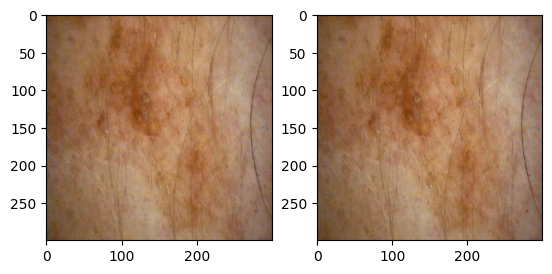

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

show([next(iter(Data))["images"], next(iter(Data))["images"]])

In [ ]:
class DataModule(L.LightningDataModule):
    def __init__(self, batch_size, num_workers, train_path, val_path, transform=None):
        super(DataModule, self).__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_transforms = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        ]
        if transform != None:
          for i in transform[::-1]:
            self.train_transforms.insert(2, i)

        self.train_transforms = transforms.Compose(self.train_transforms)

        self.test_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )
    def setup(self, stage=None):
        train_paths = get_path(self.train_path)
        val_paths = get_path(self.val_path)
        train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

        self.train_dataset = DataSet(train_paths, transform=self.train_transforms)
        self.val_dataset = DataSet(val_paths, transform=self.test_transforms)
        self.test_dataset = DataSet(test_paths, transform=self.test_transforms)


    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers)


transform = [transforms.RandomRotation(degrees=45),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)]

data_module = DataModule(8, 2, train_path, val_path, transform= transform)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [ ]:
num_train_images = len(train_loader.dataset)
print("Number of trainset Images:", num_train_images)

num_val_images = len(val_loader.dataset)
print("Number of validatation set Imgae", num_val_images)

Number of trainset Images: 6787
Number of validatation set Imgae 2121


In [ ]:
next(iter(train_loader))["images"].shape

torch.Size([8, 3, 224, 224])

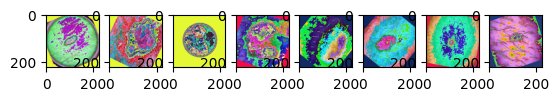

In [ ]:
images = [image for image in next(iter(train_loader))["images"]]
show(images)

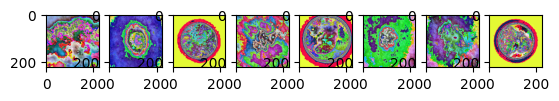

In [ ]:
images = [image for image in next(iter(val_loader))["images"]]
show(images)

## Modeling

### Data Augmentation

In [ ]:
transform = [transforms.RandomRotation(degrees=15),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)]

BATCH_SIZE = 32

aug_data_module = DataModule(BATCH_SIZE, 1, train_path, val_path, transform= transform)

nonaug_data_module = DataModule(BATCH_SIZE, 1, train_path, val_path, transform= None)

### AlexNet

In [ ]:
class AlexNet(L.LightningModule):
    def __init__(self, lr=1e-4, num_classes=2):
        super(AlexNet, self).__init__()
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6))
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)

        y_pred = y_hat.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        self.log_dict({'test_loss': test_loss, 'test_acc': accuracy,
                       'test_recall': recall, 'test_precision': precision,
                       'test_F1_score': f1}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.sigmoid(y_hat)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
# Without Data Augmentation
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/AlexNet',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = AlexNet(num_classes = 2)
trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, nonaug_data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.90193 (best 0.90193), saving model to '/content/checkpoint/AlexNet/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.90193 (best 0.90193), saving model to '/content/checkpoint/AlexNet/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' reached 0.90901 (best 0.90901), saving model to '/content/checkpoint/AlexNet/epoch=1-step=426.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' reached 0.90901 (best 0.90901), saving model to '/content/checkpoint/AlexNet/epoch=1-step=426.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' reached 0.91513 (best 0.91513), saving model to '/content/checkpoint/AlexNet/epoch=5-step=1278.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' reached 0.91513 (best 0.91513), saving model to '/content/checkpoint/AlexNet/epoch=5-step=1278.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/AlexNet/epoch=6-step=1491.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/AlexNet/epoch=6-step=1491.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' reached 0.92834 (best 0.92834), saving model to '/content/checkpoint/AlexNet/epoch=9-step=2130.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' reached 0.92834 (best 0.92834), saving model to '/content/checkpoint/AlexNet/epoch=9-step=2130.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, nonaug_data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_F1_score       │    0.9223907589912415     │
│         test_acc          │    0.9210371375083923     │
│         test_loss         │    0.19167855381965637    │
│      test_precision       │    0.9026902318000793     │
│        test_recall        │    0.9466044306755066     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19167855381965637,
  'test_acc': 0.9210371375083923,
  'test_recall': 0.9466044306755066,
  'test_precision': 0.9026902318000793,
  'test_F1_score': 0.9223907589912415}]

In [ ]:
# With Data Augmentation
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/AlexNet',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = AlexNet(num_classes = 2)
trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, aug_data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /content/checkpoint/AlexNet exists and is not emp

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.85431 (best 0.85431), saving model to '/content/checkpoint/AlexNet/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.85431 (best 0.85431), saving model to '/content/checkpoint/AlexNet/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' reached 0.89816 (best 0.89816), saving model to '/content/checkpoint/AlexNet/epoch=2-step=639.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' reached 0.89816 (best 0.89816), saving model to '/content/checkpoint/AlexNet/epoch=2-step=639.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/AlexNet/epoch=4-step=1065.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/AlexNet/epoch=4-step=1065.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, aug_data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_F1_score       │    0.9113807082176208     │
│         test_acc          │    0.9045374393463135     │
│         test_loss         │    0.2405177801847458     │
│      test_precision       │    0.8641765117645264     │
│        test_recall        │    0.9673498868942261     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2405177801847458,
  'test_acc': 0.9045374393463135,
  'test_recall': 0.9673498868942261,
  'test_precision': 0.8641765117645264,
  'test_F1_score': 0.9113807082176208}]

### VGG

In [ ]:
class VGG(nn.Module):
    def __init__(self, cfg, num_classes=2, batch_norm=False):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg, batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg, batch_norm):
        layers = []
        in_channels = 3
        vgg_config = {
            'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 'C1_256', 'M', 512, 512, 'C1_512', 'M', 512, 512, 'C1_512', 'M'],
            'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
            'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        }

        for v in vgg_config[cfg]:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            elif 'C1_' in str(v):
                conv1_channels = int(v.split('_')[1])
                conv1d = nn.Conv2d(in_channels, conv1_channels, kernel_size=1)
                if batch_norm:
                    layers += [conv1d, nn.BatchNorm2d(conv1_channels), nn.ReLU(inplace=True)]
                else:
                    layers += [conv1d, nn.ReLU(inplace=True)]
                in_channels = conv1_channels
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


class CustomVGG(L.LightningModule):
    def __init__(self, cfg='D', num_classes=2, lr=1e-4, batch_norm=False):
        super(CustomVGG, self).__init__()
        self.model = VGG(cfg, num_classes, batch_norm)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        #test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        y_pred = y_hat.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        self.log_dict({'test_loss': test_loss, 'test_acc': accuracy,
                       'test_recall': recall, 'test_precision': precision,
                       'test_F1_score': f1}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.sigmoid(y_hat)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

 VGG 16  


In [ ]:
# Without Data Augmentation
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/VGG',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = CustomVGG(num_classes= 2, batch_norm= False)
trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, nonaug_data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.86280 (best 0.86280), saving model to '/content/checkpoint/VGG/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.86280 (best 0.86280), saving model to '/content/checkpoint/VGG/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' reached 0.88826 (best 0.88826), saving model to '/content/checkpoint/VGG/epoch=1-step=426.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' reached 0.88826 (best 0.88826), saving model to '/content/checkpoint/VGG/epoch=1-step=426.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' reached 0.91089 (best 0.91089), saving model to '/content/checkpoint/VGG/epoch=2-step=639.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' reached 0.91089 (best 0.91089), saving model to '/content/checkpoint/VGG/epoch=2-step=639.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' reached 0.92504 (best 0.92504), saving model to '/content/checkpoint/VGG/epoch=5-step=1278.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' reached 0.92504 (best 0.92504), saving model to '/content/checkpoint/VGG/epoch=5-step=1278.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' reached 0.92739 (best 0.92739), saving model to '/content/checkpoint/VGG/epoch=8-step=1917.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' reached 0.92739 (best 0.92739), saving model to '/content/checkpoint/VGG/epoch=8-step=1917.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, nonaug_data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_F1_score       │    0.9144852757453918     │
│         test_acc          │    0.9169121980667114     │
│         test_loss         │    0.22247855365276337    │
│      test_precision       │    0.9388687610626221     │
│        test_recall        │    0.8953794836997986     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22247855365276337,
  'test_acc': 0.9169121980667114,
  'test_recall': 0.8953794836997986,
  'test_precision': 0.9388687610626221,
  'test_F1_score': 0.9144852757453918}]

In [ ]:
### With Data Augmentation
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/VGG',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = CustomVGG(num_classes= 2, batch_norm= False)

trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, aug_data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /content/checkpoint/VGG exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.83923 (best 0.83923), saving model to '/content/checkpoint/VGG/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.83923 (best 0.83923), saving model to '/content/checkpoint/VGG/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' reached 0.88732 (best 0.88732), saving model to '/content/checkpoint/VGG/epoch=1-step=426.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' reached 0.88732 (best 0.88732), saving model to '/content/checkpoint/VGG/epoch=1-step=426.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' reached 0.89533 (best 0.89533), saving model to '/content/checkpoint/VGG/epoch=2-step=639.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' reached 0.89533 (best 0.89533), saving model to '/content/checkpoint/VGG/epoch=2-step=639.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' reached 0.90005 (best 0.90005), saving model to '/content/checkpoint/VGG/epoch=6-step=1491.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' reached 0.90005 (best 0.90005), saving model to '/content/checkpoint/VGG/epoch=6-step=1491.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' reached 0.90806 (best 0.90806), saving model to '/content/checkpoint/VGG/epoch=7-step=1704.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' reached 0.90806 (best 0.90806), saving model to '/content/checkpoint/VGG/epoch=7-step=1704.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' reached 0.90948 (best 0.90948), saving model to '/content/checkpoint/VGG/epoch=9-step=2130.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' reached 0.90948 (best 0.90948), saving model to '/content/checkpoint/VGG/epoch=9-step=2130.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, aug_data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_F1_score       │    0.9118407964706421     │
│         test_acc          │    0.9074838161468506     │
│         test_loss         │    0.22104614973068237    │
│      test_precision       │    0.8767200112342834     │
│        test_recall        │    0.9541273713111877     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22104614973068237,
  'test_acc': 0.9074838161468506,
  'test_recall': 0.9541273713111877,
  'test_precision': 0.8767200112342834,
  'test_F1_score': 0.9118407964706421}]

### ResNet

In [ ]:
class ResNet(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_classes=2):
    super(ResNet, self).__init__()
    backbone = torchvision.models.resnet50(weights="DEFAULT")
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

  def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

  def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        #test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        y_pred = y_hat.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        self.log_dict({'test_loss': test_loss, 'test_acc': accuracy,
                       'test_recall': recall, 'test_precision': precision,
                       'test_F1_score': f1}, prog_bar=True)
        return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.sigmoid(y_hat)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}
  '''
  def predict_step(self, batch, batch_idx, dataloader_idx=None):
      x = batch["image"]
      y_pred = self(x)
      self.log_dict({"predict": y_pred}, prog_bar=True)
  '''
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)  #
    return optimizer

In [ ]:
## Without Data Augmentation
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/ResNet',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = ResNet(num_classes = 2)
trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, nonaug_data_module)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.9MB/s]
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.91608 (best 0.91608), saving model to '/content/checkpoint/ResNet/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.91608 (best 0.91608), saving model to '/content/checkpoint/ResNet/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' reached 0.91796 (best 0.91796), saving model to '/content/checkpoint/ResNet/epoch=1-step=426.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' reached 0.91796 (best 0.91796), saving model to '/content/checkpoint/ResNet/epoch=1-step=426.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/ResNet/epoch=2-step=639.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/ResNet/epoch=2-step=639.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' reached 0.92409 (best 0.92409), saving model to '/content/checkpoint/ResNet/epoch=4-step=1065.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' reached 0.92409 (best 0.92409), saving model to '/content/checkpoint/ResNet/epoch=4-step=1065.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' reached 0.92692 (best 0.92692), saving model to '/content/checkpoint/ResNet/epoch=7-step=1704.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' reached 0.92692 (best 0.92692), saving model to '/content/checkpoint/ResNet/epoch=7-step=1704.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' reached 0.92739 (best 0.92739), saving model to '/content/checkpoint/ResNet/epoch=8-step=1917.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' reached 0.92739 (best 0.92739), saving model to '/content/checkpoint/ResNet/epoch=8-step=1917.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, nonaug_data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_F1_score       │    0.9297730326652527     │
│         test_acc          │    0.9281084537506104     │
│         test_loss         │    0.1805715709924698     │
│      test_precision       │    0.9203900098800659     │
│        test_recall        │    0.9433205127716064     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1805715709924698,
  'test_acc': 0.9281084537506104,
  'test_recall': 0.9433205127716064,
  'test_precision': 0.9203900098800659,
  'test_F1_score': 0.9297730326652527}]

In [ ]:
## With Data Augmentation
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/ResNet',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = ResNet(num_classes = 2)
trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, aug_data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /content/checkpoint/ResNet exists and is not empt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.91466 (best 0.91466), saving model to '/content/checkpoint/ResNet/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.91466 (best 0.91466), saving model to '/content/checkpoint/ResNet/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' reached 0.91655 (best 0.91655), saving model to '/content/checkpoint/ResNet/epoch=2-step=639.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' reached 0.91655 (best 0.91655), saving model to '/content/checkpoint/ResNet/epoch=2-step=639.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/ResNet/epoch=3-step=852.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/ResNet/epoch=3-step=852.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' reached 0.92362 (best 0.92362), saving model to '/content/checkpoint/ResNet/epoch=6-step=1491.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' reached 0.92362 (best 0.92362), saving model to '/content/checkpoint/ResNet/epoch=6-step=1491.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' reached 0.92409 (best 0.92409), saving model to '/content/checkpoint/ResNet/epoch=7-step=1704.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' reached 0.92409 (best 0.92409), saving model to '/content/checkpoint/ResNet/epoch=7-step=1704.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' reached 0.92645 (best 0.92645), saving model to '/content/checkpoint/ResNet/epoch=9-step=2130.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' reached 0.92645 (best 0.92645), saving model to '/content/checkpoint/ResNet/epoch=9-step=2130.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, aug_data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_F1_score       │    0.9245210289955139     │
│         test_acc          │    0.9228049516677856     │
│         test_loss         │    0.20028339326381683    │
│      test_precision       │    0.9189717173576355     │
│        test_recall        │    0.9345825910568237     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.20028339326381683,
  'test_acc': 0.9228049516677856,
  'test_recall': 0.9345825910568237,
  'test_precision': 0.9189717173576355,
  'test_F1_score': 0.9245210289955139}]

### Load model

In [ ]:
test_loader = nonaug_data_module.test_dataloader()
model = ResNet.load_from_checkpoint("/content/checkpoint/ResNet/epoch=9-step=2130.ckpt")
predictions_ = trainer.predict(model, test_loader)
all_max_indices = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices, i['y_pred']])

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]